In [1]:
from __future__ import print_function

import tensorflow as tf
from tensorflow.contrib import rnn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('../Tensorflow Examples Models/mnist', one_hot=True)

from keras import backend as K

#Clear TF memory
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

C:\Users\StrikeWade\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting ../Tensorflow Examples Models/mnist\train-images-idx3-ubyte.gz
Extracting ../Tensorflow Examples Models/mnist\train-labels-idx1-ubyte.gz
Extracting ../Tensorflow Examples Models/mnist\t10k-images-idx3-ubyte.gz
Extracting ../Tensorflow Examples Models/mnist\t10k-labels-idx1-ubyte.gz


Using TensorFlow backend.


In [2]:
#Training Params
learning_rate = 0.001
training_step = 10000
batch_size = 128
display_step = 200

#Network Params
num_input = 28 #MNIST data input (img shape = 28*28)
timesteps = 28 #timesteps
num_hidden = 128 #Hidden layer num of features
num_classes = 10 # 0-9 digits

#TF placeholder graph input
x = tf.placeholder(dtype=tf.float32, shape=[None, timesteps, num_input])
y = tf.placeholder(dtype=tf.float32, shape=[None, num_classes])

In [3]:
#Define weights and biases
weights={
    #Hidden layer weights -> 2*n_hidden because of forward + backward celss
    'out': tf.Variable(tf.random_normal(shape=[2*num_hidden, num_classes]))
}

biases={
    'out': tf.Variable(tf.random_normal(shape=[num_classes]))
}

In [4]:
def BiRNN(x, weights, biases):
    #Prepare data shape to match rnn function requirements
    #Current data input shape: (batch_size, timesteps, num_input)
    #Require shape: 'timesteps' tensor list of shape (batch_size, num_input) 
    
    #Unstack to get a list of 'timesteps' tensors of shape (batch_size, num_input)
    x = tf.unstack(x, timesteps, 1)
    
    #Define LSTM cells with tensorflow
    #Forward direction cell
    lstm_fw_cell = rnn.BasicLSTMCell(num_hidden, forget_bias=1.0)
    #Backward direction cell
    lstm_bw_cell = rnn.BasicLSTMCell(num_hidden, forget_bias=1.0)
    
    #Get LSTM cell output
    try:
        outputs, _, _ = rnn.static_bidirectional_rnn(cell_fw=lstm_fw_cell, 
                                                     cell_bw=lstm_bw_cell, 
                                                     inputs=x, 
                                                     dtype=tf.float32)
    except Exception: 
        outputs = rnn.static_bidirectional_rnn(cell_fw=lstm_fw_cell, 
                                               cell_bw=lstm_bw_cell, 
                                               inputs=x, 
                                               dtype=tf.float32)
        
    #Linear activation, using RNN inner loop last output
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

In [5]:
logits = BiRNN(x, weights, biases)
prediction = tf.nn.softmax(logits=logits)

#Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)
train_op = optimizer.minimize(loss_op)

#Evaluate model (with test logits, for dropout to be disabled)
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

#Init global variable
init = tf.global_variables_initializer()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [6]:
#Start training
training_loss =[]

with tf.Session() as sess:
    sess.run(init)
    
    for step in range(1, training_step+1):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        #Reshape data to get 28 seq of 28 elements
        batch_x = batch_x.reshape((batch_size, timesteps, num_input))
        
        #Run optimization op (backprop)
        sess.run(train_op, feed_dict={x: batch_x, y: batch_y})
        if step % display_step == 0 or step == 1:
            #Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={x: batch_x, y: batch_y})
            training_loss.append(loss)
            
            print('Step: ', str(step), '\n    Minibatch loss= {:.4f}'.format(loss), '\n    Training accuracy= {:.3f}'.format(acc))
            
    print('-->BIRNN training completed!!!')
    
    #Calculate accuracy for 128 mnist test images
    test_len = 128
    test_data = mnist.test.images[:test_len].reshape((-1, timesteps, num_input))
    test_label = mnist.test.labels[:test_len]
    
    print('-->Testing Accuracy: ', sess.run(accuracy, feed_dict={x: test_data, y: test_label}))

Step:  1 
    Minibatch loss= 3.1286 
    Training accuracy= 0.125
Step:  200 
    Minibatch loss= 1.9725 
    Training accuracy= 0.383
Step:  400 
    Minibatch loss= 1.9383 
    Training accuracy= 0.297
Step:  600 
    Minibatch loss= 1.7900 
    Training accuracy= 0.367
Step:  800 
    Minibatch loss= 1.6193 
    Training accuracy= 0.617
Step:  1000 
    Minibatch loss= 1.6306 
    Training accuracy= 0.438
Step:  1200 
    Minibatch loss= 1.5440 
    Training accuracy= 0.547
Step:  1400 
    Minibatch loss= 1.5337 
    Training accuracy= 0.508
Step:  1600 
    Minibatch loss= 1.5292 
    Training accuracy= 0.492
Step:  1800 
    Minibatch loss= 1.2987 
    Training accuracy= 0.609
Step:  2000 
    Minibatch loss= 1.2257 
    Training accuracy= 0.578
Step:  2200 
    Minibatch loss= 1.2717 
    Training accuracy= 0.539
Step:  2400 
    Minibatch loss= 1.0954 
    Training accuracy= 0.664
Step:  2600 
    Minibatch loss= 1.2088 
    Training accuracy= 0.531
Step:  2800 
    Minibatch 

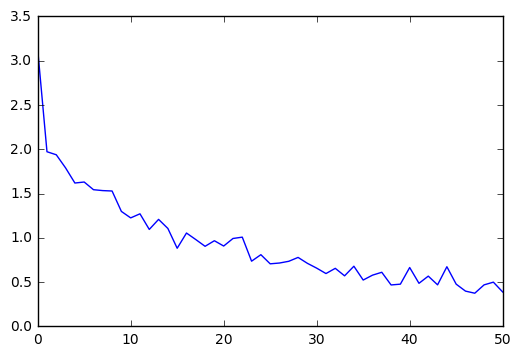

In [11]:
plt.plot(training_loss)
plt.show()